In [1]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

In [2]:
# Loading data sets
sss_batchB = pd.read_csv('/home/jovyan/covid-data/COVID_BatchB_ready_POLINA.csv')
print(f'There are {sss_batchB.shape} rows and cols in the Batch B')

There are (5169, 1884) rows and cols in the Batch B


In [3]:
# Look for duplicated columns
dup_cols = fun.getDuplicateColumns(sss_batchB)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['AreaShape_BoundingBoxArea_cytoplasm', 'AreaShape_MinFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'AreaShape_MaxFeretDiameter_cytoplasm', 'Intensity_MeanIntensity_illumMITO_cells.1', 'Location_Center_X_cytoplasm', 'Location_Center_Y_cytoplasm', 'AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'Location_Center_X_cells', 'Location_Center_Y_nuclei', 'Location_Center_X_nuclei', 'Location_Center_Y_cells']


In [4]:
# I need to keep Intensity_MeanIntensity_illumMITO_cells.1 for later computations
iaux = dup_cols.index("Intensity_MeanIntensity_illumMITO_cells.1")
dup_cols[iaux]= 'Intensity_MeanIntensity_illumMITO_cells'

# Drop repeated columns
sss_batchB = sss_batchB.drop(dup_cols, axis=1)

In [5]:
compound_volume0 = ['CBK309099','CBK290175','CBK290175','CBK290175','CBK290175','CBK308178','CBK308178','CBK308178','CBK308178',
                    'CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309392',
                    'CBK309392','CBK290631','CBK309251','CBK309251','CBK309251','CBK309251','CBK290950','CBK290950','CBK290950','CBK290950']

# Removing compounds from cell profiler data frame
compound_volume0_idx = [sss_batchB.index[sss_batchB['ID_covid'] == comp].to_list() for comp in compound_volume0]
compound_volume0_idx = [item for sublist in compound_volume0_idx for item in sublist]
sss_batchB = sss_batchB.drop(compound_volume0_idx)
print(f'The shape if Batch B is {sss_batchB.shape} so far')

The shape if Batch B is (5160, 1870) so far


In [6]:
filter_col = [col for col in sss_batchB.columns if 'MITO' in col]
print(f'There are {len(filter_col)} columns containig info about MITO')
print(filter_col[-1])

There are 364 columns containig info about MITO
Intensity_MeanIntensity_illumMITO_cells.1


In [7]:
filter_col = filter_col[:-1] # IF Intensity_MeanIntensity_illumMITO_cells.1 is in the last position

In [8]:
# Drop MITO columns
sss_batchB = sss_batchB.drop(filter_col, axis=1)

In [9]:
print(f'Now the shape of Batch B is: {sss_batchB.shape}')

Now the shape of Batch B is: (5160, 1507)


### Now we add the information for training + cleaning

First the cell profiler

In [10]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchB.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)
cell_profiler = cell_profiler.rename(columns={'Intensity_MeanIntensity_illumMITO_cells.1': 'Target'})
cell_profiler.head()

<ipython-input-10-6b0cb6ad345d>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchB.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target
0,155.000000,1763.321836,2392.479974,1040.469101,1121.808755,992.439454,1073.791338,1015.952347,1097.333064,1.146009,...,-0.079766,-0.062142,0.028843,-0.050329,0.002352,-0.048181,0.101544,-0.051319,0.009876,0.014975
1,177.666667,1778.498450,2375.840700,1074.039635,1102.388670,1025.847336,1054.453537,1049.466080,1077.953347,1.129649,...,-0.011443,-0.007264,0.105147,0.024870,0.097344,-0.034144,0.026505,-0.058919,0.039985,0.013005
2,195.777778,1749.652953,2346.427388,1088.936040,1080.753557,1041.279389,1032.913473,1064.616892,1056.326780,1.137315,...,0.053927,0.050008,-0.048896,0.042183,-0.003522,0.021115,0.016468,-0.013247,-0.070871,0.013788
3,216.571429,2047.965141,2694.202403,1113.122298,1116.560567,1061.842105,1065.028003,1086.982445,1090.280350,1.120502,...,-0.057359,-0.103094,-0.044613,0.105152,-0.068018,0.031788,0.020980,-0.000444,0.049044,0.006809
4,157.125000,1743.363036,2376.359863,1108.081848,1074.743853,1060.249785,1026.842564,1083.631113,1050.306489,1.149625,...,-0.004677,0.049752,0.052904,0.008830,0.070198,-0.087356,0.059546,0.053790,-0.011938,0.013995


### Feature selection

So far I have filtered all the columns that contained something related to the MITO chanell. Now, according to the paper "A phenomic approach for antiviral drug discovery", there are features, specifically correlation, 
neighbours, concavalin and syto, that are more important. Hence, I am going to filter more to use only that information. 

In [11]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler_B = cell_profiler[filtered_features+['Target']]

In [12]:
filtered_cell_profiler_B

,Granularity_10_illumSYTO_nuclei,Granularity_11_illumSYTO_nuclei,Granularity_12_illumSYTO_nuclei,Granularity_13_illumSYTO_nuclei,Granularity_14_illumSYTO_nuclei,Granularity_15_illumSYTO_nuclei,Granularity_16_illumSYTO_nuclei,Granularity_1_illumSYTO_nuclei,Granularity_2_illumSYTO_nuclei,Granularity_3_illumSYTO_nuclei,...,Correlation_RWC_illumHOECHST_illumCONC_cytoplasm,Correlation_RWC_illumHOECHST_illumPHAandWGA_cytoplasm,Correlation_RWC_illumHOECHST_illumSYTO_cytoplasm,Correlation_RWC_illumPHAandWGA_illumCONC_cytoplasm,Correlation_RWC_illumPHAandWGA_illumHOECHST_cytoplasm,Correlation_RWC_illumPHAandWGA_illumSYTO_cytoplasm,Correlation_RWC_illumSYTO_illumCONC_cytoplasm,Correlation_RWC_illumSYTO_illumHOECHST_cytoplasm,Correlation_RWC_illumSYTO_illumPHAandWGA_cytoplasm,Target
0,5.036074,4.045871,3.701231,2.976809,2.923950,2.166730,2.287887,12.074159,2.213671,3.594409,...,0.668297,0.788363,0.776957,0.670813,0.544883,0.838390,0.776913,0.616491,0.917410,0.014975
1,4.321689,3.623019,3.061378,2.656599,2.155505,1.921066,1.756346,13.189354,2.268531,3.724780,...,0.676479,0.784949,0.779240,0.674424,0.529992,0.838668,0.773285,0.597442,0.908687,0.013005
2,4.755632,3.627676,3.381285,2.693872,2.195047,2.133893,1.536719,9.976382,2.778201,4.143379,...,0.682199,0.780595,0.772278,0.703561,0.537257,0.839807,0.793541,0.605488,0.916414,0.013788
3,4.164948,3.212185,2.550792,2.159480,1.721807,1.293209,1.468429,14.068313,2.125489,3.714472,...,0.711177,0.771760,0.781160,0.692886,0.497564,0.833036,0.780067,0.561020,0.884716,0.006809
4,4.389827,3.652513,3.104480,2.698492,2.429443,2.057912,1.880075,11.564207,2.176082,3.715027,...,0.657812,0.791037,0.786559,0.645229,0.549538,0.844488,0.746402,0.622248,0.915533,0.013995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164,4.076411,3.837551,3.065481,3.036789,2.646879,2.225419,1.959465,11.987888,2.494503,3.624097,...,0.675844,0.784177,0.784154,0.680145,0.539775,0.843267,0.774568,0.607549,0.905907,0.015038
5165,4.653916,3.878406,3.286776,3.034016,2.635375,2.446386,2.077198,8.541350,2.688379,4.062471,...,0.702157,0.784581,0.787652,0.717875,0.511995,0.847052,0.801154,0.583767,0.921299,0.013815
5166,4.481191,3.767212,3.352855,3.245919,2.523410,1.960557,1.631931,8.787539,2.711964,3.947765,...,0.689623,0.787520,0.765525,0.754183,0.593841,0.850788,0.830121,0.655829,0.931191,0.016064
5167,4.873445,3.996099,3.261522,2.913878,2.606938,2.307421,2.053859,8.602307,2.886905,4.049433,...,0.690528,0.781952,0.782137,0.708196,0.529648,0.843113,0.795628,0.604710,0.920878,0.013780


## Now training

### 1. Creating training and tests sets

In [13]:
# We get the input values
X_filtered =  filtered_cell_profiler_B.iloc[:,:-1]

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered

# Output values
y = 1000*cell_profiler.iloc[:,-1].reset_index(drop=True)

**Evaluating baseline models in the training dataset**

In [14]:
#Parameters
thr = 9.6
cv_k = 5

In [15]:
# build multiple linear regression model
model1 = LinearRegression()
model2 = Lasso(random_state=0)
model3 = Ridge(random_state=0)
model4 = svm.SVR()
MODELS = [model1, model2, model3, model4]

MMS_x_filt, BF1_scores_x_filt = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

---- Model: LinearRegression()
---- Model: Lasso(random_state=0)
---- Model: Ridge(random_state=0)
---- Model: SVR()


In [16]:
# Second part
model5 = DecisionTreeRegressor(random_state=0)
model6 = RandomForestRegressor(random_state=0)
model7 = BaggingRegressor(random_state=0)
model8 = AdaBoostRegressor(random_state=0)
MODELS = [model5, model6, model7, model8]

MMS_x_filt_2, BF1_scores_x_filt_2 = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

---- Model: DecisionTreeRegressor(random_state=0)
---- Model: RandomForestRegressor(random_state=0)
---- Model: BaggingRegressor(random_state=0)
---- Model: AdaBoostRegressor(random_state=0)


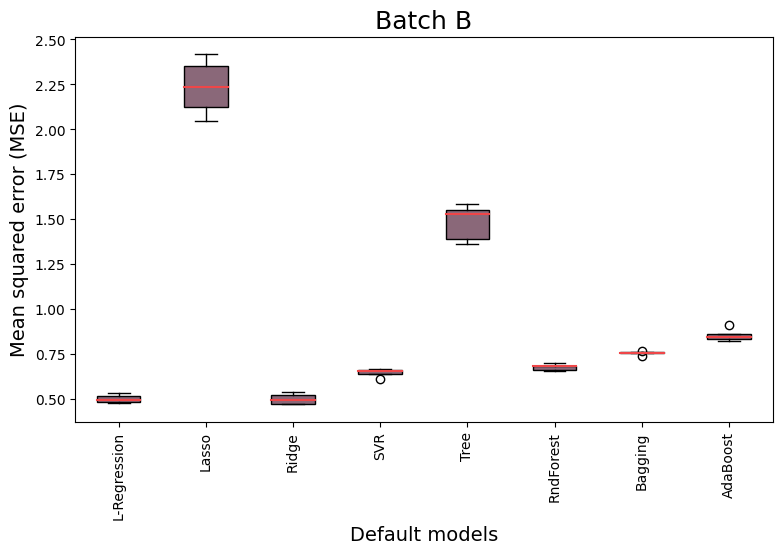

In [53]:
# Showing results
exp1 = list(MMS_x_filt.values())+list(MMS_x_filt_2.values())
medianprops = dict(linestyle='-', linewidth=1.5, color=(.937, .275, .282))
models_name = ['L-Regression','Lasso','Ridge','SVR','Tree','RndForest','Bagging','AdaBoost'] #For labels
fig, ax = plt.subplots(1, 1, figsize=(9,5))
bp = ax.boxplot(exp1,labels=models_name,patch_artist=True, medianprops=medianprops)
#Changing colour of the boxes
for patch, color in zip(bp['boxes'], [(.345, .157, .255, 0.7)]*8):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k')   
ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=14)   
ax.set_xlabel('Default models', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)
ax.grid(False)
plt.xticks(rotation=90)
#plt.savefig('regression_default_mse_batchB.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Hyper-parameter tunning

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# Sets for training
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=6752)

In [55]:
# ----------- LINEAR REGRESSION

#Create the grid
grid_vals1 = {'fit_intercept': [True, False]}
grid_lr1 = GridSearchCV(estimator=model1, param_grid=grid_vals1, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result1 = grid_lr1.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result1.best_score_)
print('Best Hyperparameters: %s' % result1.best_params_)

Best Score: -0.5305043992599454
Best Hyperparameters: {'fit_intercept': True}


In [56]:
# ----------- LINEAR REGRESSION WITH RIDGE REGULARIZATION

#Create the grid
grid_vals3 = {'alpha': [0.001,0.01,0.1,1.0,1.1,1.3,1.5], 'fit_intercept': [True, False]}
grid_lr3 = GridSearchCV(estimator=model3, param_grid=grid_vals3, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result = grid_lr3.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.5228776400272508
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': True}


In [57]:
# ----------- SUPPORT VECTOR MACHINES FOR REGRESSION

#Create the grid
grid_vals4 = {'kernel': ["poly", "rbf", "sigmoid"], 'gamma': [1.0, 0.1, 1e-2], 'C': [1, 10, 30, 50, 80, 100]}
grid_lr4 = GridSearchCV(estimator=model4, param_grid=grid_vals4, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result4 = grid_lr4.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result4.best_score_)
print('Best Hyperparameters: %s' % result4.best_params_)

Best Score: -0.9837709123142089
Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [59]:
# ----------- DECISION TREE: I will use this as the base estimator for bagging

#Create the grid
grid_vals5 = {'splitter':['best', 'random'], 'min_samples_split':[2,5,7,10], 'max_depth':[None,5,10,15,20], }
grid_lr5 = GridSearchCV(estimator=model5, param_grid=grid_vals5, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result5 = grid_lr5.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result5.best_score_)
print('Best Hyperparameters: %s' % result5.best_params_)

Best Score: -1.0752850576141033
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'}


In [22]:
# ----------- RANDOM FOREST

#Create the grid
grid_vals6 = {'n_estimators': [30,50,100,150,200], 'max_depth': [None,3,5,9,12], 'min_samples_leaf': [1,2,3],'random_state': [0],'n_jobs':[-1]}
grid_lr6 = GridSearchCV(estimator=model6, param_grid=grid_vals6, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result6 = grid_lr6.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result6.best_score_)
print('Best Hyperparameters: %s' % result6.best_params_)

Best Score: -0.697865996340799
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}


In [24]:
# ----------- BAGGING

#Create the grid
base = DecisionTreeRegressor(max_depth = 5, min_samples_split = 10, splitter = "best", random_state=0)
grid_vals7 = {'base_estimator':[base],'n_estimators': [10,30,50,70,100], 'max_features':[0.25,0.5,1.0]}
grid_lr7 = GridSearchCV(estimator=model7, param_grid=grid_vals7, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result7 = grid_lr7.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result7.best_score_)
print('Best Hyperparameters: %s' % result7.best_params_)

Best Score: -0.8278874094446117
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'max_features': 0.5, 'n_estimators': 100}


In [25]:
# ----------- ADABOOST

#Create the grid
grid_vals8 = {'base_estimator':[base], 'n_estimators': [10,30,50,70,100], 'learning_rate': [1.5, 1.0, 0.1, 1e-2]}
grid_lr8 = GridSearchCV(estimator=model8, param_grid=grid_vals8, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result8 = grid_lr8.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result8.best_score_)
print('Best Hyperparameters: %s' % result8.best_params_)

Best Score: -0.7200496008310457
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'learning_rate': 1.5, 'n_estimators': 100}


**Best models comparision**

In [42]:
# Building the models
best_ridge = Ridge(alpha=0.1, random_state=0) #{'alpha': 0.1, 'fit_intercept': True}
best_svr = svm.SVR(C=10, gamma=0.01, kernel='rbf') #{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
best_tree = DecisionTreeRegressor(max_depth = 5, min_samples_split=10, splitter='best', random_state=0) #{'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'}
best_rf = RandomForestRegressor(max_depth=None, min_samples_leaf = 2, n_estimators = 200, n_jobs=-1,random_state=0)
#{'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}
best_bag = BaggingRegressor(base_estimator = best_tree, max_features = 0.5, n_estimators=100, random_state=0)
#{'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'max_features': 0.5, 'n_estimators': 100}
best_ada = AdaBoostRegressor(base_estimator = best_tree, learning_rate=1.5 ,n_estimators = 100, random_state=0)
#{'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'learning_rate': 1.5, 'n_estimators': 100}


BEST_MODELS = [model1,best_ridge, best_svr, best_tree, best_rf, best_bag, best_ada]

In [43]:
Best_MMS_x_filt_v2, Best_BF1_scores_x_filt_v2 = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = BEST_MODELS)

---- Model: LinearRegression()
---- Model: Ridge(alpha=0.1, random_state=0)
---- Model: SVR(C=10, gamma=0.01)
---- Model: DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0)
---- Model: RandomForestRegressor(min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                      random_state=0)
---- Model: BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      min_samples_split=10,
                                                      random_state=0),
                 max_features=0.5, n_estimators=100, random_state=0)
---- Model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       min_samples_split=10,
                                                       random_state=0),
                  learning_rate=1.5, n_estimators=100, random_state=0)


In [55]:
accuracy = list(Best_MMS_x_filt_v2.values())
f1score = list(Best_BF1_scores_x_filt_v2.values())
models_name = ['L-Regression','Ridge','SVR','Tree', 'RndForest', 'Bagging', 'AdabBoost']

medianprops = dict(linestyle='-', linewidth=1.5, color=(.98, .702, .447))

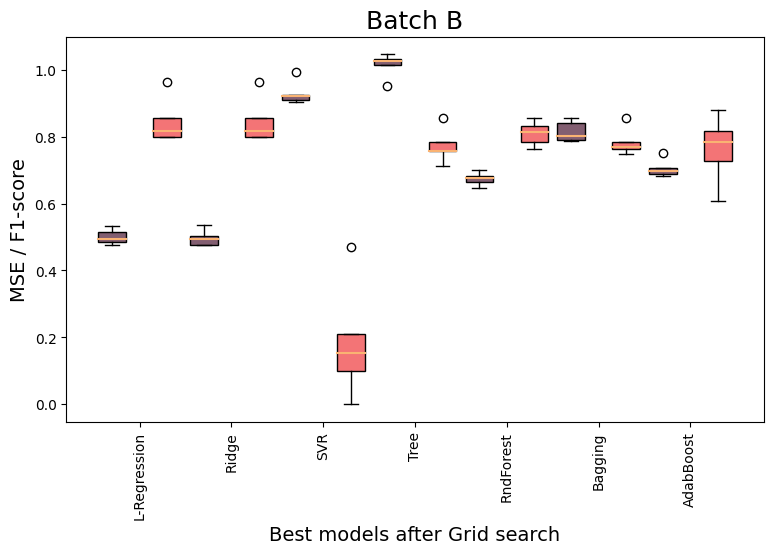

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
bp0 = ax.boxplot(accuracy, labels = None, positions = np.arange(np.array(accuracy).shape[0])-0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)
bp1 = ax.boxplot(f1score, labels = None, positions = np.arange(np.array(f1score).shape[0])+0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)

#Changing colour
for patch, color in zip(bp0['boxes'], [(.345, .157, .255, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 
for patch, color in zip(bp1['boxes'], [(.937, .275, .282, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 

ax.set_ylabel('MSE / F1-score', color="black", fontsize=14)   
ax.set_xlabel('Best models after Grid search', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)
ax.grid(False)
plt.xticks(ticks= np.arange(0,7),labels = models_name,rotation=90)

#plt.savefig('regression_grid_batchB.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Adding conformal prediction to the best model

In [47]:
import reg_icp as ricp

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2,random_state=0)
# Split data into proper training set and clibration set
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.3,random_state=0)

In [48]:
## Ridge regression
intervals_ridge, testPred_ridge = ricp.ICPRegression(X_train, y_train, X_calib, y_calib, X_test, best_ridge, returnPredictions = False)

In [49]:
icp_result_ridge = pd.DataFrame(intervals_ridge,columns=['Lower_bound', 'Upper_bound'])
icp_result_ridge['y_predicted'] = testPred_ridge
icp_result_ridge['y_test'] = y_test.values.tolist()
icp_result_ridge=icp_result_ridge.sort_values(by='y_predicted').reset_index(drop=True)

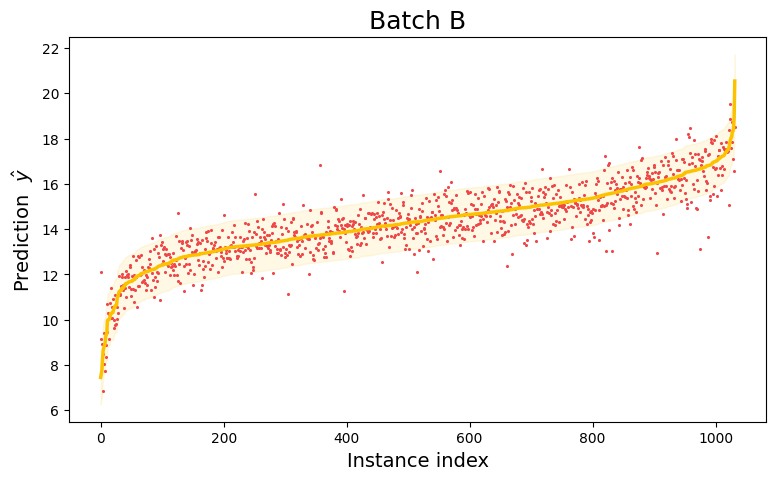

In [58]:
npoints = icp_result_ridge.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(icp_result_ridge.index[:npoints],icp_result_ridge['y_predicted'][:npoints], color=[.988, .761, 0], linewidth=2.5)
ax.fill_between(icp_result_ridge.index[:npoints],icp_result_ridge['Lower_bound'][:npoints], 
                icp_result_ridge['Upper_bound'][:npoints], color=[.988, .761, 0],alpha=0.1)
ax.scatter(icp_result_ridge.index[:npoints],icp_result_ridge['y_test'][:npoints], marker = 'o', s=2,
        color=[.937, .275, .282],linewidth=0.8)

ax.set_ylabel('Prediction  $\^y$', color="black", fontsize=14)   
ax.set_xlabel('Instance index', color="black", fontsize=14)
ax.set_title('Batch B', color="black", fontsize=18)

#plt.savefig('cp_Ridge_regre_batchB.jpg',bbox_inches='tight', dpi=150)
plt.show()